In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
%matplotlib inline
save_image=True

### Compute Camera Calibration Matrix
Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.
Here the images for camera calibration are taken from folder `camera_cal` using glob function we will read all the images assuming all images belongs to chess board. Once the images are read we can make use of the function camera calibration function to calibrate the camera.

`def camera_calibration` creates objp numpy array with 9x6 = 54 points starts from 0,0... 8,5. Loop over the images, convert the images to Gray using cv2.cvtColor function. Now we need to find the corners in the 9x6 board using the cv2.findChessboardCorners function. Once the call for the above is successful we append 3d points in objpoints & imgpoints in image plane.

once we have objpoints and imgpoints we can now calibrate using the cv2.calibrateCamera function Which returns the camera matrix(mtx), distortion coefficients(dist), rotation(rvecs) and translation vectors(tvecs)
More information about the cv2 function is here.[OpenCV Docs](https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html)

In [3]:
def camera_calibration(images, nx, ny):
    
    #create objp np.array with nx*ny items of type float32, 9x6 = 54 items of [0. 0. 0.]
    objp = np.zeros((ny*nx, 3), np.float32)
    
    #create a grid from [0,0]...[5,4]... [8,5]
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    #Arrays to store objpoints and imgpoints
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane
   
    # Step through the image list and search for chess board corners
    for fname in tqdm(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        #since it is cv2.imread color format will be in BGR and not RGB
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        #If corners are found add object points and image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    # once we have objpoints and imgpoints we can now calibrate using the cv2.calibrateCamera function
    # Which returns the camera matrix(mtx), distortion coefficients(dist), rotation(rvecs) and translation vectors(tvecs)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None, None)
        
    return mtx, dist

    
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)    

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


**Provide an example of a distortion corrected calibration image**

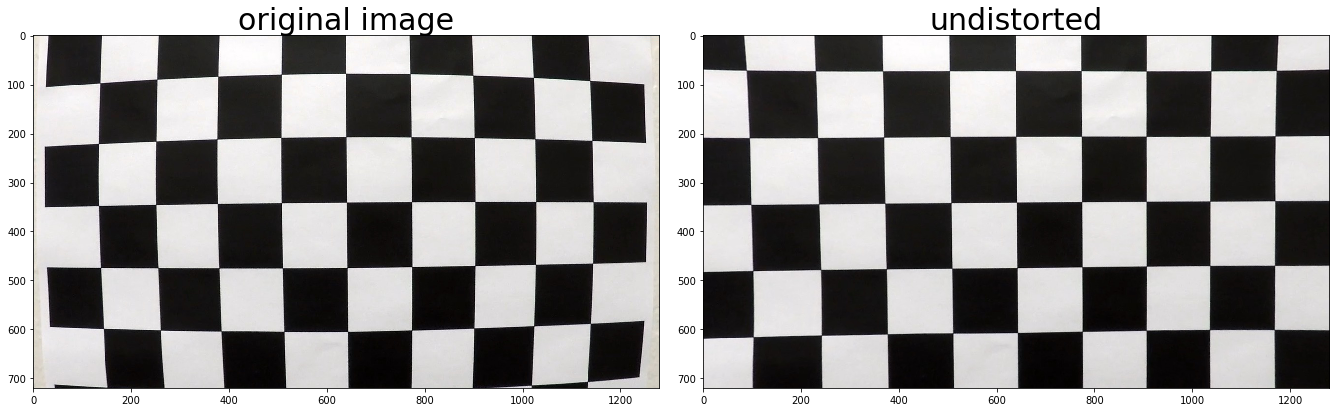

In [4]:
img = mpimg.imread("camera_cal/calibration1.jpg")
undistort = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undistort)
ax2.set_title('undistorted', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

if save_image:
    cv2.imwrite("output_images/undistorted.jpg", cv2.cvtColor(undistort, cv2.COLOR_RGB2BGR))

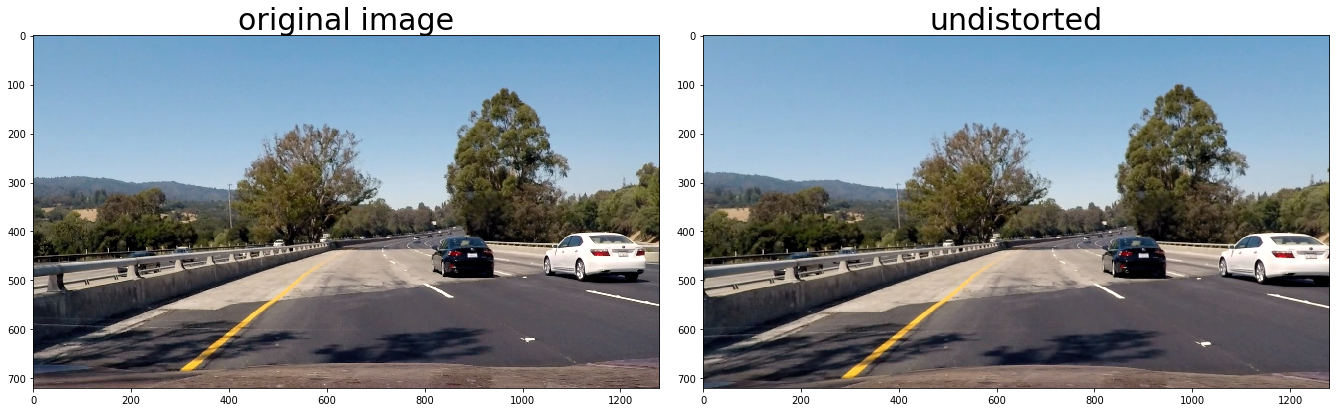

In [5]:
#Undistorting the Raod Image
img = mpimg.imread("test_images/test4.jpg")
undistort_road = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undistort_road)
ax2.set_title('undistorted', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

if save_image:
    cv2.imwrite("output_images/undistorted_road.jpg", cv2.cvtColor(undistort_road, cv2.COLOR_RGB2BGR))

### Applying Perspective Transform 
A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.
During perspective transform first we will convert the image to gray then find the corners using the 
`cv2.FindChessboardCorners(image, patternSize, flags=CV_CALIB_CB_ADAPTIVE_THRESH) → corners `
Once the corners are obtained then use the corners to drwChessboardCorners
`cv2.DrawChessboardCorners(image, patternSize, corners, patternWasFound) ->None`
calculate the src & destination vertices and use that to calculate the Perspective Transform matrix of size 3x3.
`cv2.GetPerspectiveTransform(src, dst, mapMatrix) → None`
Using the M(3x3) transform matrix apply perspective Transformation to an image using warpPerspective
`cv.WarpPerspective(src, dst, mapMatrix, flags=CV_INTER_LINEAR+CV_WARP_FILL_OUTLIERS, fillval=(0, 0, 0, 0)) → None`

The function warpPerspective transforms the source image using the specified matrix: 
![image.png](assets/mtransform.png)

In [6]:
def corners_unwarp(undist, nx, ny, mtx, dist):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    #findchessboardcorners takes grayscale image, patternSize in this case it is 9x6, corners will be the output array of detected corners.
    # FLAGS => None, some valid options are CALIB_CB_FAST_CHECK to avoid looking for chessboard.
    img_size = (undist.shape[1], undist.shape[0])
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret:
        # drawChessboardCorners will render  the detected chessboard corners.
        #Takes in undistrorted image 8bit, patternsize (9x6), corners(returned from findchessboardcorners call), ret(return val)
        cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
        if ret:
            #Coordinates of quadrangle vertices in the source image.
            src = np.float32([corners[0][0], corners[nx - 1][0], corners[-1][0], corners[-nx][0]])
            #Coordinates of quadrangle vertices in the destination image.
            dst = np.float32([[100, 100], [1150,100], [1150, 650], [100, 650]])
            #Calculate a perspective transform from four pairs of the corresponding points src & dst
            M = cv2.getPerspectiveTransform(src, dst)
            #Now using the transformation matrix (3x3) we can apply the warpPerspective on undistorted image
            # https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#warpperspective
            warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
            
    return warped, M
        

### Perspective Transform on Chessboard

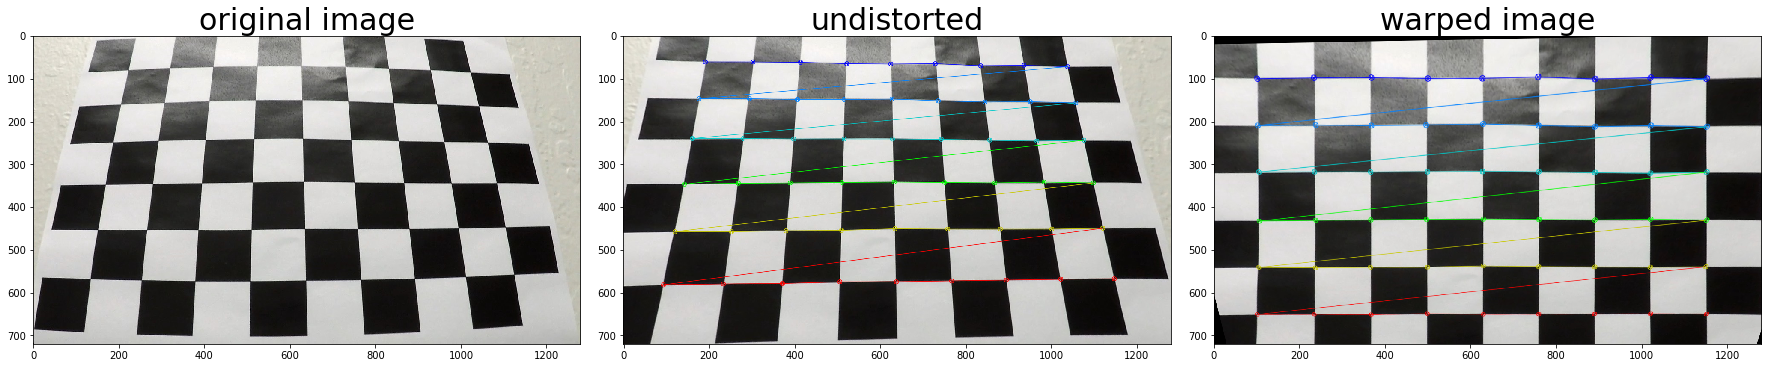

In [7]:
img = mpimg.imread("camera_cal/calibration3.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)

warped_img, perspective_M = corners_unwarp(undist, 9, 6, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=30)
ax3.imshow(warped_img)
ax3.set_title('warped image', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

if save_image:
    cv2.imwrite("output_images/warped_chessboard.jpg", cv2.cvtColor(warped_img, cv2.COLOR_RGB2BGR))

### Bounding box / ROI
1. Identify the ROI Points via trial and error best use cv2.polylines function to adjust the region you are intersted.
2. Create a black mask and use cv2.fillpoly and preserve the color based on whether image is gray or not img.shape[2]
3. Do bitwise_and operation to get the image.

(<matplotlib.image.AxesImage at 0x2c31aff09e8>,
 <matplotlib.text.Text at 0x2c31afd10f0>)

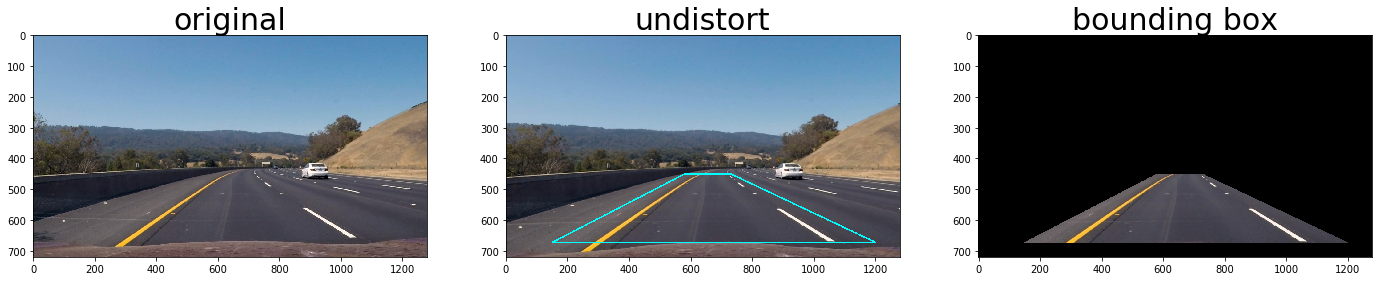

In [8]:
# Caculate the Region of interest using trial & Error method.

left_bottom = (150, 672)
left_top = (580, 450)
right_bottom = (1200, 672)
right_top = (730, 450)
roi_points = [[left_top, right_top, right_bottom, left_bottom]]


def bounding_box(img, roi_points):
    mask = np.zeros_like(img)
    img_size = img.shape
    vertices = np.array(roi_points, dtype=np.int32)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
        #print(ignore_mask_color)
    else:
        ignore_mask_color = 255
        
    #The function fillPoly fills an area bounded by several polygonal contours
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    roi_image = cv2.bitwise_and(img, mask)
    return roi_image

img = mpimg.imread("test_images/test3.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
poly = np.array(roi_points, np.int32)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
cv2.polylines(undist, poly, True, (0,255,255), 3)
axs[1].imshow(undist), axs[1].set_title('undistort', fontsize=30)
axs[2].imshow(roi), axs[2].set_title('bounding box', fontsize=30)

### Perspective Transform and Warp Perspective
identify the source points which is our region of interest/ROI/bounding box.

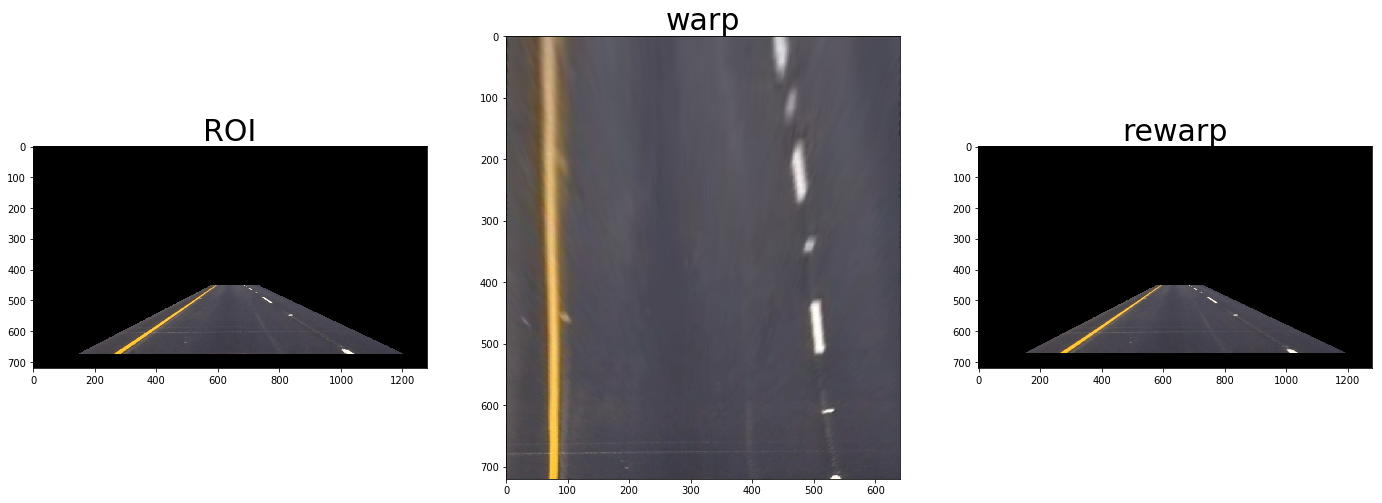

In [9]:
def image_unwarp(img, roi_points):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(roi_points)
    dst = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    # Given src and dst points, calculate the perspective transform matrix
    M  = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (640,720), flags=cv2.INTER_LINEAR)
    return warped

def image_rewarp(img, roipoints):
    dst = np.float32(roi_points)
    src = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    rewarped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    return rewarped

img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
rewarped = image_rewarp(warped, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(roi, cmap='gray'), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('warp', fontsize=30)
axs[2].imshow(rewarped, cmap='gray'), axs[2].set_title('rewarp', fontsize=30)

if save_image:
     cv2.imwrite("output_images/warped_road.jpg", cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

### Binary Sobel Filter
Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction

(<matplotlib.image.AxesImage at 0x2c315a46160>,
 <matplotlib.text.Text at 0x2c315b2d208>)

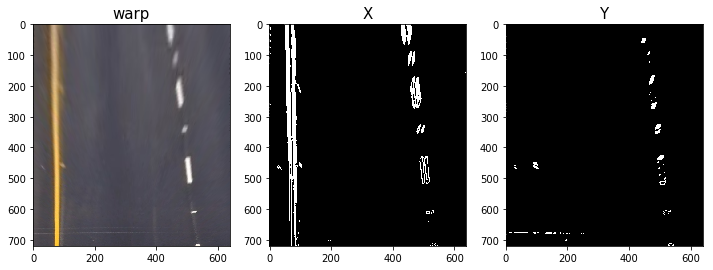

In [10]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # GaussianBlur filter will reduce or removes noise while keeping edges relatively sharp.
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    
    if (orient=='x'):
        sobel = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
sxbinary = abs_sobel_thresh(warped, 'x', 9, (20, 100))
sybinary = abs_sobel_thresh(warped, 'y', 9, (20, 100))

f, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=15)
axs[1].imshow(sxbinary, cmap='gray'), axs[1].set_title('X', fontsize=15)
axs[2].imshow(sybinary, cmap='gray'), axs[2].set_title('Y', fontsize=15)

### Magnitude of Gradient
The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients. For a gradient in both the xx and yy directions, the magnitude is the square root of the sum of the squares.

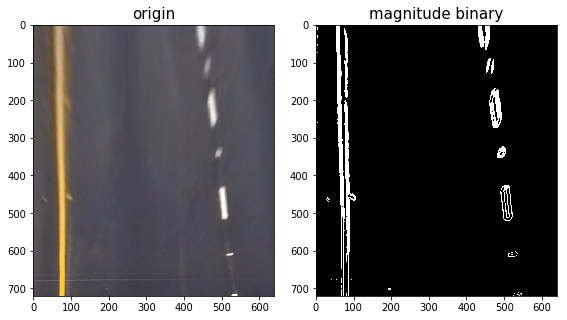

In [11]:
def mag_thresh(img, sobel_kernel, mag_thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary
    
img = mpimg.imread("test_images/straight_lines1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
mag_binary = mag_thresh(warped, 9, mag_thresh=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('origin', fontsize=15)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('magnitude binary', fontsize=15)

### Direction of the Gradient
The direction of the gradient is simply the inverse tangent (arctangent) of the yy gradient divided by the xx gradient:
arctan(sobely/sobelx)

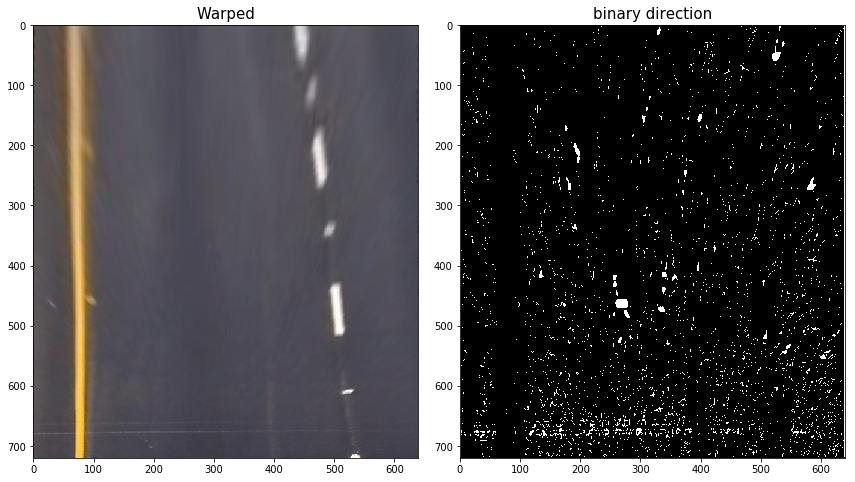

In [12]:
def dir_threshold(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary = np.zeros_like(gradir)
    binary[(gradir >= thresh[0]) & (gradir <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/straight_lines1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
dir_binary = dir_threshold(warped, 15, (1.5, 2.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped', fontsize=15)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('binary direction', fontsize=15)

### Combined Gradient to Isolate Lane Lines
Our aim is to isolate the Lane lines for that reason we will focus on using various aspects of gradient measurement such as sobelx, sobely, magnitude and direction to find out the Lane lines. specifically the thresholds of the x and y gradients, the overall magnitude, and the gradient direction to focus on pixels that are likely to be part of the Lane lines

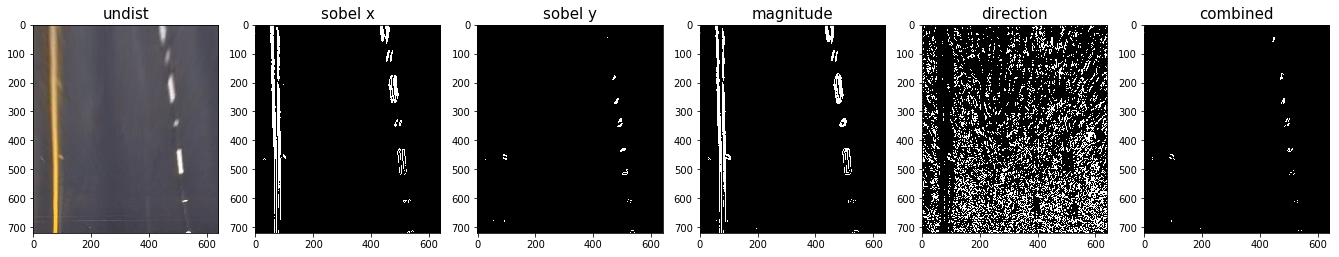

In [13]:
img = mpimg.imread("test_images/straight_lines1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
sx_binary = abs_sobel_thresh(warped, 'x', 9, (30, 100))
sy_binary = abs_sobel_thresh(warped, 'y', 9, (30, 100))
mag_binary = mag_thresh(warped, 9, (30, 100))
dir_binary = dir_threshold(warped, 15, (0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


f, axs = plt.subplots(1, 6, figsize=(18, 9))
axs[0].imshow(warped), axs[0].set_title('undist', fontsize=15)
axs[1].imshow(sx_binary, cmap='gray') ,axs[1].set_title('sobel x', fontsize=15)
axs[2].imshow(sy_binary, cmap='gray'), axs[2].set_title('sobel y', fontsize=15)
axs[3].imshow(mag_binary, cmap='gray'), axs[3].set_title('magnitude', fontsize=15)
axs[4].imshow(dir_binary, cmap='gray'), axs[4].set_title('direction', fontsize=15)
axs[5].imshow(combined, cmap='gray'), axs[5].set_title('combined', fontsize=15)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

### Color Space : RGB

(<matplotlib.image.AxesImage at 0x2c31a4caa20>,
 <matplotlib.text.Text at 0x2c31a49d0b8>)

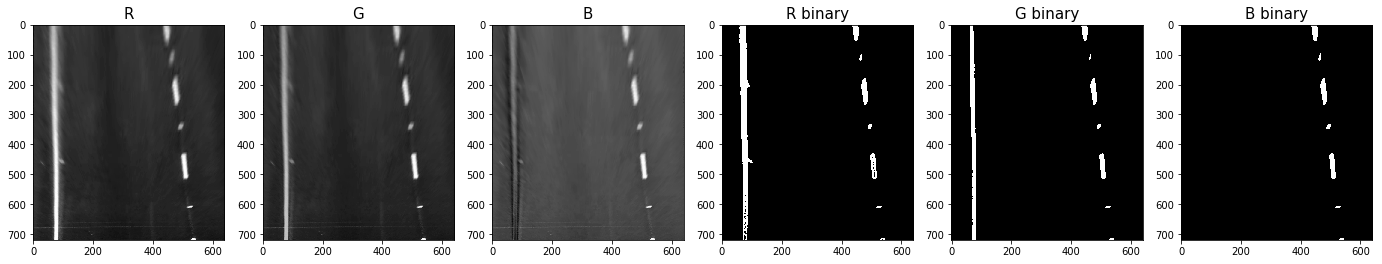

In [14]:
def rgb_thresh(img, channel, thresh):
    channel = img[:, :, channel]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel < thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
R = warped[:,:,0]
G = warped[:,:,1]
B = warped[:,:,2]

r_binary = rgb_thresh(warped, 0, (150, 255))
g_binary = rgb_thresh(warped, 1, (150, 255))
b_binary = rgb_thresh(warped, 2, (150, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(R, cmap='gray') ,axs[0].set_title('R', fontsize=15)
axs[1].imshow(G, cmap='gray'), axs[1].set_title('G', fontsize=15)
axs[2].imshow(B, cmap='gray'), axs[2].set_title('B', fontsize=15)
axs[3].imshow(r_binary, cmap='gray') ,axs[3].set_title('R binary', fontsize=15)
axs[4].imshow(g_binary, cmap='gray'), axs[4].set_title('G binary', fontsize=15)
axs[5].imshow(b_binary, cmap='gray'), axs[5].set_title('B binary', fontsize=15)


### Color Space : HLS

(<matplotlib.image.AxesImage at 0x2c31d141898>,
 <matplotlib.text.Text at 0x2c31d11a240>)

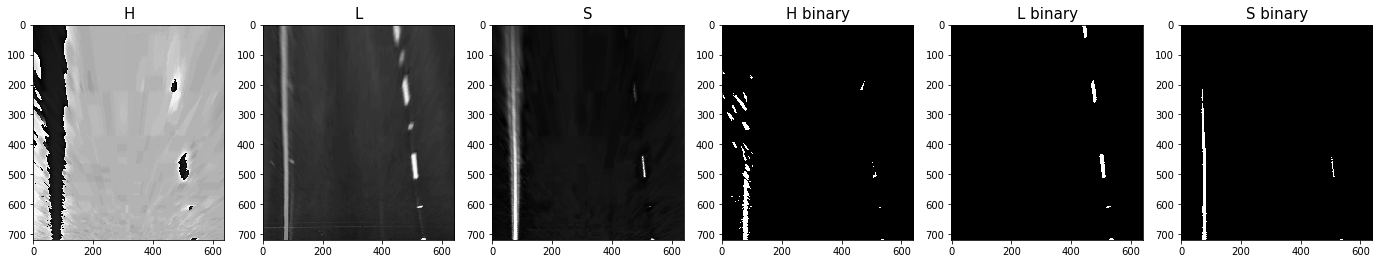

In [15]:
def hls_thresh(img, channel_num, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel_num]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/straight_lines1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
H_binary = hls_thresh(warped, 0, (19, 50))
L_binary = hls_thresh(warped, 1, (195, 255))
S_binary = hls_thresh(warped, 2, (150, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(H, cmap='gray') ,axs[0].set_title('H', fontsize=15)
axs[1].imshow(L, cmap='gray'), axs[1].set_title('L', fontsize=15)
axs[2].imshow(S, cmap='gray'), axs[2].set_title('S', fontsize=15)
axs[3].imshow(H_binary, cmap='gray') ,axs[3].set_title('H binary', fontsize=15)
axs[4].imshow(L_binary, cmap='gray'), axs[4].set_title('L binary', fontsize=15)
axs[5].imshow(S_binary, cmap='gray'), axs[5].set_title('S binary', fontsize=15)

### Exploring Color Space : HSV

(<matplotlib.image.AxesImage at 0x2c31eacf208>,
 <matplotlib.text.Text at 0x2c31df80518>)

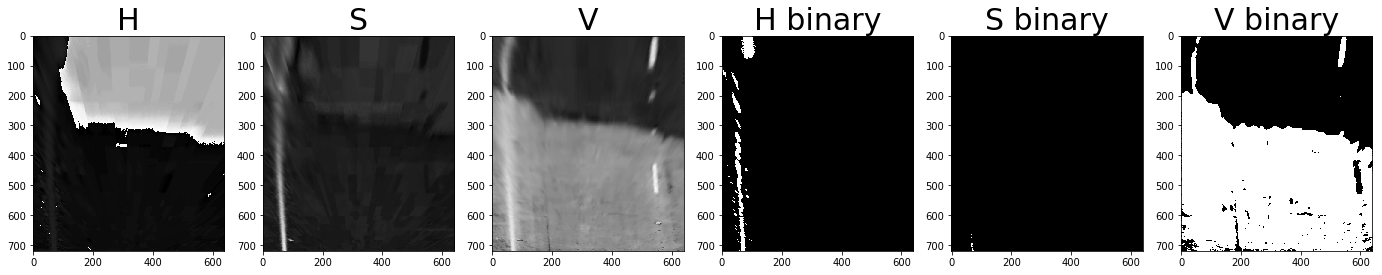

In [23]:
def hsv_thresh(img, channel_num, thresh):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    channel = hsv[:,:,channel_num]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("582/orig_frame_600.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
hsv = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]
H_binary = hsv_thresh(warped, 0, (19, 50))
S_binary = hsv_thresh(warped, 1, (195, 255))
V_binary = hsv_thresh(warped, 2, (150, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(H, cmap='gray') ,axs[0].set_title('H', fontsize=30)
axs[1].imshow(S, cmap='gray'), axs[1].set_title('S', fontsize=30)
axs[2].imshow(V, cmap='gray'), axs[2].set_title('V', fontsize=30)
axs[3].imshow(H_binary, cmap='gray') ,axs[3].set_title('H binary', fontsize=30)
axs[4].imshow(S_binary, cmap='gray'), axs[4].set_title('S binary', fontsize=30)
axs[5].imshow(V_binary, cmap='gray'), axs[5].set_title('V binary', fontsize=30)

### Combine gradient and color

In [17]:
def color_threshold(img, channel='rgb', thresh=(220,255)):
    #Convert the image to RGB.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if channel is 'hls':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif channel is 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif channel is 'yuv':    
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif channel is 'ycrcb':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif channel is 'lab':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif channel is 'luv':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    
    img_ch1 = img[:,:,0]
    img_ch2 = img[:,:,1]
    img_ch3 = img[:,:,2]

    bin_ch1 = np.zeros_like(img_ch1)
    bin_ch2 = np.zeros_like(img_ch2)
    bin_ch3 = np.zeros_like(img_ch3)

    bin_ch1[(img_ch1 > thresh[0]) & (img_ch1 <= thresh[1])] = 1
    bin_ch2[(img_ch2 > thresh[0]) & (img_ch2 <= thresh[1])] = 1
    bin_ch3[(img_ch3 > thresh[0]) & (img_ch3 <= thresh[1])] = 1
    
    return bin_ch1, bin_ch2, bin_ch3

In [18]:
def combined_color(img):
     bin_rgb_ch1, bin_rgb_ch2, bin_rgb_ch3 = color_threshold(img, channel='rgb', thresh=(230,255))
     bin_hsv_ch1, bin_hsv_ch2, bin_hsv_ch3 = color_threshold(img, channel='hsv', thresh=(230,255))    
     bin_luv_ch1, bin_luv_ch2, bin_luv_ch3 = color_threshold(img, channel='luv', thresh=(157,255))

     binary = np.zeros_like(bin_rgb_ch1)
    
     binary[(bin_rgb_ch1 == 1) | (bin_hsv_ch3 == 1) | (bin_luv_ch3 == 1) ] = 1
    
     return binary

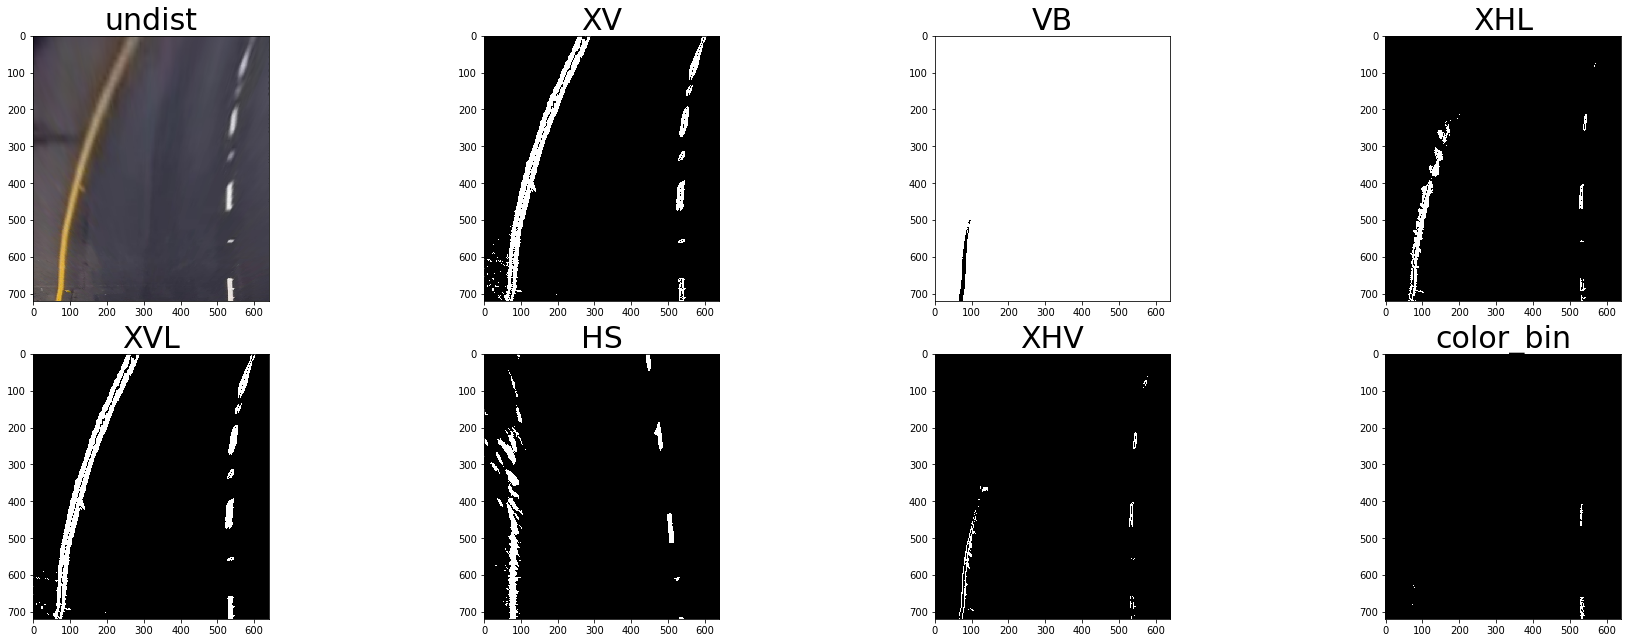

In [85]:
# combine sobel x and value 
def xv_thresh(img, x_thresh, s_thresh):
    sxbinary = abs_sobel_thresh(img, 'x', 3, x_thresh)
    v_binary = hsv_thresh(img, 2, s_thresh)

    xv_binary = np.zeros_like(sxbinary)
    xv_binary[(sxbinary == 1) & (v_binary == 1)] = 1

    return xv_binary

#combine value and blue
def vb_thresh(img, v_thresh, b_thresh):    
    v_binary = hsv_thresh(img, 2, v_thresh)
    b_binary = rgb_thresh(img, 2, b_thresh)
    vb_binary = np.zeros_like(sxbinary)
    vb_binary[(b_binary == 1) | (v_binary == 1)] = 1
    return vb_binary

#combine Saturation & Value
def sv_thresh(img, s_thresh, v_thresh):
    v_binary = hsv_thresh(img, 2, v_thresh)
    s_binary = hsv_thresh(img, 1, s_thresh)
    
    sv_binary = np.zeros_like(s_binary)
    sv_binary[(s_binary == 1) | (v_binary == 1)] = 1
    
    return sv_binary

#combine value, sobel x filter, L value from HSL
def xvl_thresh(img, x_thresh, v_thresh, l_thresh):
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    v_binary = hsv_thresh(img, 2, v_thresh)

    xv_binary = np.zeros_like(v_binary)
    xv_binary[(sxbinary == 1) & (v_binary == 1)] = 1
    
    l_binary = hls_thresh(img, 1, l_thresh)
    xvl_binary = np.zeros_like(xv_binary)
    xvl_binary[(xv_binary == 1) | (l_binary == 1)] = 1
    
    return xvl_binary

def hs_thresh(img, h_thresh, s_thresh):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hls[:,:,0]
    s = hls[:,:,1]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    s_binary = np.zeros_like(s)
    s_binary[(s > s_thresh[0]) & (s <= s_thresh[1])] = 1
    hs_binary = np.zeros_like(s)
    hs_binary[(h_binary == 1) | (s_binary == 1)] = 1
    return hs_binary

def xhv_thresh(img, x_thresh, h_thresh, v_thresh):
    #tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, (9,9))
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    v = hsv[:,:,2]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    v_binary = np.zeros_like(v)
    v_binary[(v > v_thresh[0]) & (v <= v_thresh[1])] = 1
    hv_binary = np.zeros_like(v)
    hv_binary[(h_binary == 1) | (v_binary == 1)] = 1
    
     
    
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    xhv_binary = np.zeros_like(sxbinary)
    xhv_binary[(hv_binary == 1) & (sxbinary == 1)] = 1
        
    
    return xhv_binary

def xhl_thresh(img, x_thresh, h_thresh, l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l > l_thresh[0]) & (l <= l_thresh[1])] = 1
    hl_binary = np.zeros_like(l)
    hl_binary[(h_binary == 1) | (l_binary == 1)] = 1
    
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    xhl_binary = np.zeros_like(sxbinary)
    xhl_binary[(hl_binary == 1) & (sxbinary == 1)] = 1
    
    return xhl_binary


#img = mpimg.imread("test_images/test6.jpg")
#img = mpimg.imread("582/orig_frame_590.jpg")
img = mpimg.imread("606/orig_frame_625.jpg")
#img = mpimg.imread("1022/orig_frame_1041.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)

xv_binary = xv_thresh(warped, (3, 200), (100, 255))
vb_binary = vb_thresh(warped, (3, 200), (100, 255))
sv_binary = sv_thresh(warped, (3,200), (100, 255))
xvl_binary = xvl_thresh(warped, (5, 200), (100, 255), (195, 255))
hs_binary = hs_thresh(warped, (18, 50), (195, 255))
xhv_binary = xhv_thresh(warped, (10, 80), (20, 58), (190, 255))
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
color_binary = combined_color(warped)


f, axs = plt.subplots(2, 4, figsize=(24, 9))
axs[0,0].imshow(warped), axs[0,0].set_title('undist', fontsize=30)
axs[0,1].imshow(xv_binary, cmap='gray'), axs[0,1].set_title('XV', fontsize=30)
axs[0,2].imshow(vb_binary, cmap='gray'), axs[0,2].set_title('VB', fontsize=30)
axs[0,3].imshow(xhl_binary, cmap='gray'), axs[0,3].set_title('XHL', fontsize=30)
axs[1,0].imshow(xvl_binary, cmap='gray'), axs[1,0].set_title('XVL', fontsize=30)
axs[1,1].imshow(hs_binary, cmap='gray'), axs[1,1].set_title('HS', fontsize=30)
axs[1,2].imshow(xhv_binary, cmap='gray'), axs[1,2].set_title('XHV', fontsize=30)
axs[1,3].imshow(color_binary, cmap='gray'), axs[1,3].set_title('color_bin', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

## Histogram 

([<matplotlib.lines.Line2D at 0x2c327c34ac8>],
 <matplotlib.text.Text at 0x2c327c0fac8>)

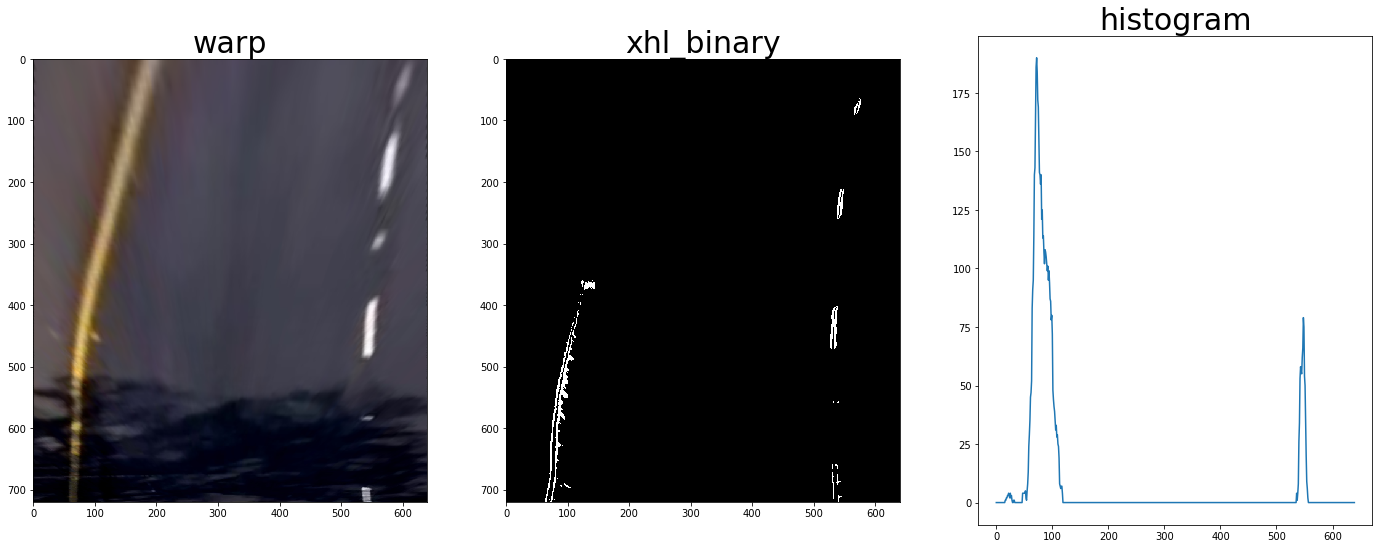

In [100]:
#img = mpimg.imread("test_images/test4.jpg")
#img = mpimg.imread("test_images/test6.jpg")
#img = mpimg.imread("582/orig_frame_590.jpg")
#img = mpimg.imread("606/orig_frame_630.jpg")
img = mpimg.imread("1022/orig_frame_1046.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
histogram = np.sum(xhl_binary[xhl_binary.shape[0]//2:,:], axis=0)


f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=30)
axs[1].imshow(xhv_binary, cmap='gray'), axs[1].set_title('xhl_binary', fontsize=30)
axs[2].plot(histogram), axs[2].set_title('histogram', fontsize=30)

### Sliding Windows 

(<matplotlib.image.AxesImage at 0x2c328250860>,
 <matplotlib.text.Text at 0x2c32822a908>)

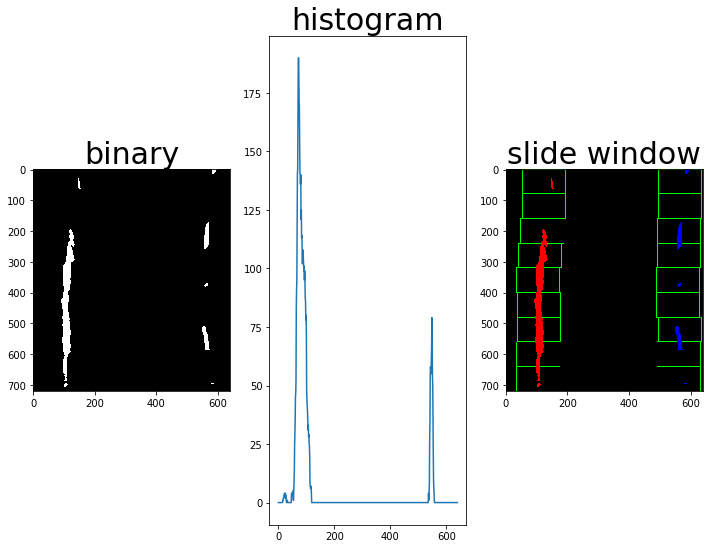

In [101]:
def sliding_window(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    nonzeroy, nonzerox = warped.nonzero()
    
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #the number of sliding windows
    nwindows = 9
    #set the height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    #current position to be updated for each window
    left_current = left_base
    right_current = right_base
    
    #set the width of the windows +/= margin
    margin = 70
    
    #set minimum number of pixels found to recenter window
    minpix = 50
    
    #create empty lists to recieve left and right lane pixes indices
    left_indices = []
    right_indices = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        #identify window boundaries in x and y (and right and left)
        win_low = warped.shape[0] - (window+1) * window_height  
        win_high = warped.shape[0] - window * window_height
        
        win_left_left = left_current - margin
        win_left_right = left_current + margin
        
        win_right_left = right_current - margin
        win_right_right = right_current + margin
        
        #draw the windows on visualization image (Rectangle drawing)
        #cv2.rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) → None
        #https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#cv2.rectangle
        #Left Side
        cv2.rectangle(out, (win_left_left, win_low), (win_left_right, win_high), (0,255,0), 2)
        #Right Side
        cv2.rectangle(out, (win_right_left, win_low), (win_right_right, win_high), (0,255,0), 2)
        
        #Now we have the window lets identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_left_left) & (nonzerox < win_left_right)).nonzero()[0]
        
        #right indice
        good_right_inds = ((nonzeroy >= win_low)& (nonzeroy < win_high) & (nonzerox >= win_right_left) & (nonzerox < win_right_right)).nonzero()[0]
        
        #append these indices in the window to the list of all windows
        left_indices.append(good_left_inds)
        right_indices.append(good_right_inds)
        
        #if you find good indices > minpix pixels, recenter next window on thier mean poistion
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        
    #concatenate all the arrays of indices
    left_indices = np.concatenate(left_indices)
    right_indices = np.concatenate(right_indices)
    
    leftx = nonzerox[left_indices]
    lefty = nonzeroy[left_indices]
    rightx = nonzerox[right_indices]
    righty = nonzeroy[right_indices]
    
    
    #draw left and right lane lines
    out[nonzeroy[left_indices], nonzerox[left_indices]] = [255, 0, 0]
    out[nonzeroy[right_indices], nonzerox[right_indices]] = [0, 0, 255]
       
    
    return left_indices, right_indices

img = mpimg.imread("test_images/test4.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
combined_binary = combined_color(warped)
out = np.dstack((combined_binary, combined_binary, combined_binary)) ** 255
left_indices, right_indices = sliding_window(combined_binary)

f, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(combined_binary, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('slide window', fontsize=30)


### Polynomial Fit
Polynomial Least Squares comprises a broad range of statistical methods for estimating an underlying polynomial that describes observations.

C:\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  app.launch_new_instance()


(<matplotlib.image.AxesImage at 0x2c3280f6ba8>,
 <matplotlib.text.Text at 0x2c3282c49e8>)

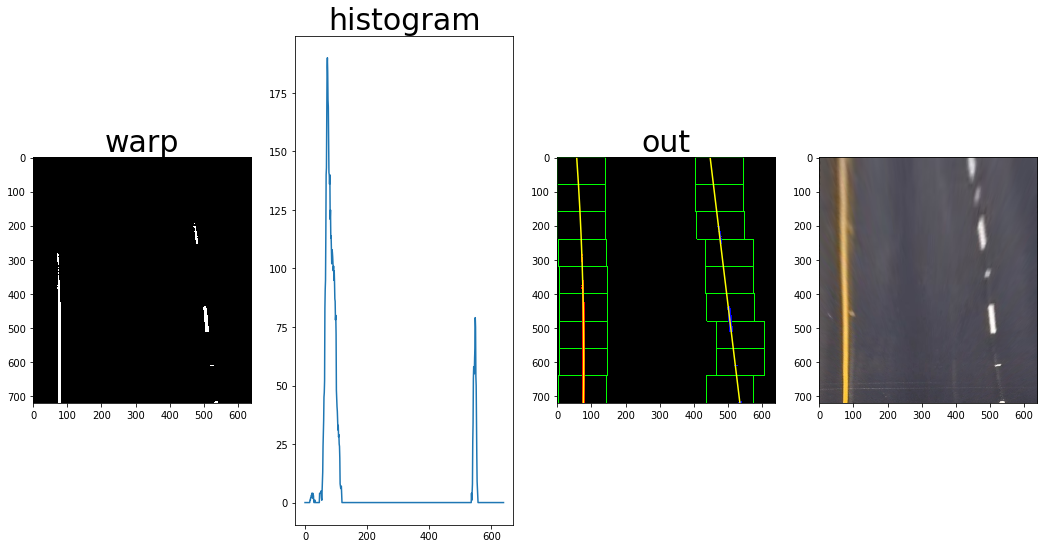

In [102]:
def polynomial_fit(warped, left_indices, right_indices, left_fit, right_fit):
    
    if (len(left_indices) ==0 | len(right_indices) ==0 ):
        return left_fit, right_fit
    
    nonzeroy, nonzerox = warped.nonzero()
    
    leftx = nonzerox[left_indices]
    lefty = nonzeroy[left_indices]
    rightx = nonzerox[right_indices]
    righty = nonzeroy[right_indices]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(((left_fit != []) & (right_fit != [])) & (left_fit[0] * right_fit[0] < 0.)):
        if(np.absolute(left_fit[1] - left_fit[1]) > 0.1):
            left_fit[0] = right_fit[0]
            left_fit[1] = right_fit[1]
            left_fit[2] = right_fit[2] - 450
        if(np.absolute(right_fit[1] - right_fit[1]) > 0.1):
            right_fit[0] = left_fit[0]
            right_fit[1] = left_fit[1]
            right_fit[2] = left_fit[2] + 450
            
    return left_fit, right_fit

#generate x and y values for plotting
def calculate_lane(left_fit, right_fit):
    left_poly = left_fit
    right_poly = right_fit
    ploty = np.linspace(0, 719, 720)
    left_fitx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2] 
    right_fitx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
    return left_fitx, right_fitx


img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
combined_binary = combined_color(warped)
out = np.dstack((combined_binary, combined_binary, combined_binary)) ** 255
left_indices, right_indices = sliding_window(combined_binary)
left_fit = []
right_fit = []
left_fit, right_fit = polynomial_fit(combined_binary, left_indices, right_indices, left_fit, right_fit)
left_lane, right_lane = calculate_lane(left_fit, right_fit)

ploty = np.linspace(0, 719, 720)

f, axs = plt.subplots(1, 4, figsize=(18, 9))
axs[0].imshow(combined_binary, cmap='gray'), axs[0].set_title('color-binary', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('out', fontsize=30)
axs[2].plot(left_lane, ploty, color='yellow'), axs[2].plot(right_lane, ploty, color='yellow')
axs[3].imshow(warped), axs[0].set_title('warp', fontsize=30)


### Tuning using polynomial data

C:\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  app.launch_new_instance()


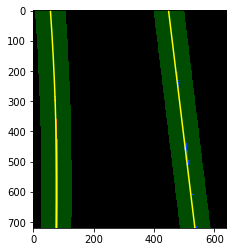

In [103]:
def modified_windows(warped, left_fit, right_fit):
    left_poly = left_fit
    right_poly = right_fit
    ploty = np.linspace(0, 719, 720)
    nonzeroy, nonzerox = warped.nonzero()
    margin = 100
    
    #using previous fit data to predict the position of the indices of lane line
    left_pre = left_poly[0] * (nonzeroy**2)  + left_poly[1]*nonzeroy + left_poly[2]
    right_pre = right_poly[0] * (nonzeroy**2) + right_poly[1] * nonzeroy + right_poly[2]
        
    #find indices position in warp between prediction +/- margin
    left_indices = ((nonzerox > left_pre - margin) & (nonzerox < left_pre + margin))
    right_indices = ((nonzerox > right_pre - margin) & (nonzerox < right_pre + margin))
    
    return left_indices, right_indices

def tuning_draw(left_lane, right_lane, left_indices, right_indices, warped):
    left_fitx = left_lane
    right_fitx = right_lane
    
    ploty = np.linspace(0, 719, 720)
    nonzeroy, nonzerox = warped.nonzero()
    
    #create an image to draw 
    out_img = np.dstack((warped, warped, warped)) ** 255
    
    window = np.zeros_like(out_img)
    
    margin = 50
    
    # Generate a polygon to illustrate the search window area and recast the x and y points into cv2.fillPolly()
    
    left_window1 = np.array([np.transpose(np.vstack([left_lane - margin, ploty]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane + margin, ploty])))])
    left_pts = np.hstack((left_window1, left_window2))
    
    #Right Window
    right_window1 = np.array([np.transpose(np.vstack([right_lane - margin, ploty]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane + margin, ploty])))])
    right_pts = np.hstack((right_window1, right_window2))

    # color in left and right line pixels
    out_img[nonzeroy[left_indices], nonzerox[left_indices]] = [255, 0, 0]
    out_img[nonzeroy[right_indices], nonzerox[right_indices]] = [0, 0, 255]

    # draw the lane onto the warped blank image
    cv2.fillPoly(window, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(window, np.int_([right_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window, 0.3, 0)
    
    return result


img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
combined_binary = combined_color(warped)
left_indices, right_indices = modified_windows(combined_binary, left_fit, right_fit)

#polynomial data
left_poly, right_poly = polynomial_fit(combined_binary, left_indices, right_indices, left_fit, right_fit)
left_lane, right_lane = calculate_lane(left_poly, right_poly)
draw_result = tuning_draw(left_lane, right_lane, left_indices, right_indices, combined_binary)

plt.imshow(draw_result)
plt.plot(left_lane, ploty, color='yellow')
plt.plot(right_lane, ploty, color='yellow')

### Measuring Curvature

In the last cell, we have located the lane line pixels, used their x and y pixel positions to fit a second order polynomial curve: 

f(y) = Ay^2 + By + Cf(y)= Ay ^ 2+ By + C

we are fitting for f(y)f(y), rather than f(x)f(x), because the lane lines in the warped image are near vertical and may have the same xx value for more than one yy value.

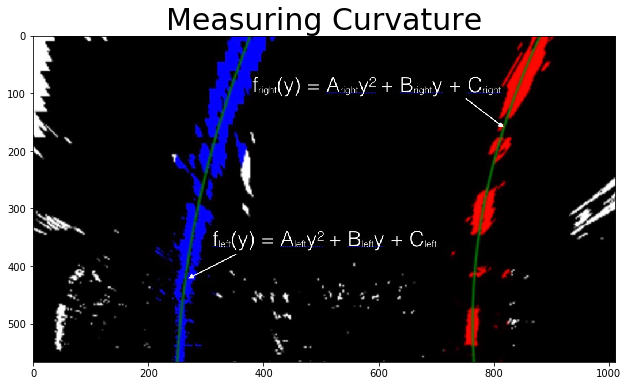

In [104]:
img =cv2.imread("./output_images/color-fit-lines.jpg")
f, ax = plt.subplots(1, 1, figsize=(12,6))
ax.imshow(img)
ax.set_title('Measuring Curvature', fontsize=30)

### Sample Implementation from Course

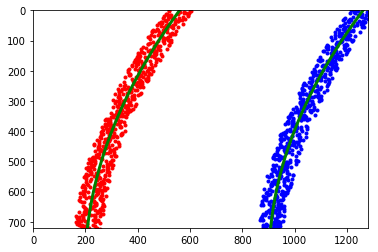

In [105]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 850, num=720)# to cover same y-range as image
quadratic_coeff = 5e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [106]:
def curvature_compute(left_poly, right_poly, ym, xm, y_eval):
    left_fit = left_poly
    right_fit = right_poly
    
    # pixel function to meter function
    l_A = left_fit[0] * xm / (ym ** 2)
    l_B = left_fit[1] * xm / ym
    
    # pixel function to meter function
    r_A = right_fit[0] * xm / (ym ** 2)
    r_B = right_fit[1] * xm / ym

    # calculate the new radius of curvature
    left_curcerad = ((1 + (2 * l_A * y_eval * ym + l_B) ** 2) ** 1.5) / np.absolute(2 * l_A)
    right_curcerad = ((1 + (2 * r_A * y_eval * ym + r_B) ** 2) ** 1.5) / np.absolute(2 * r_A)
    return left_curcerad, right_curcerad

left_curcerad, right_curcerad = curvature_compute(left_poly, right_poly, 30 / 720, 3.7 / 500, 720)
print(left_curcerad, 'm', right_curcerad, 'm')

1981.0379954861423 m 125226.63635551588 m


C:\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  app.launch_new_instance()


(<matplotlib.image.AxesImage at 0x2c329abf198>,
 <matplotlib.text.Text at 0x2c329a92b00>)

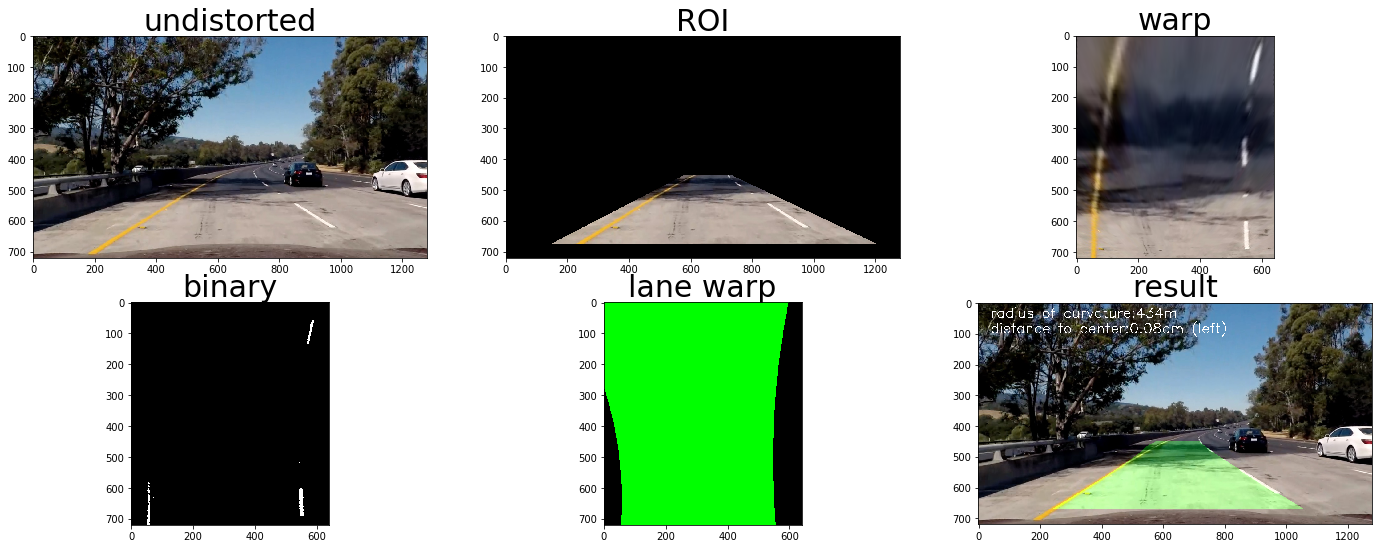

In [107]:
def draw_lane(warped, left_lane, right_lane):
    # create zero fille np.array
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    lane_draw = np.dstack((warp_zero, warp_zero, warp_zero))

    
    ploty = np.linspace(0, 719, 720)
    left_pts = np.array([np.transpose(np.vstack([left_lane, ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_lane, ploty])))])
    pts = np.hstack((left_pts, right_pts))

    # draw the lane onto the warped blank image
    cv2.fillPoly(lane_draw, np.int_([pts]), (0, 255, 0))
    
    return lane_draw


def final_draw(undist, draw_lane, roi_points, curvature, distance):
    # use the image_rewarp
    rewarped = image_rewarp(draw_lane, roi_points)
    result = cv2.addWeighted(undist, 1, rewarped, 0.3, 0)
    
    result = cv2.putText(result, 'radius of curvature:' + str(curvature) + 'm', (40, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    if (distance > 0):
        result = cv2.putText(result, 'distance to center:' + str(distance) + 'cm ' + '(right)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    else:
        result = cv2.putText(result, 'distance to center:' + str(-distance) + 'cm ' + '(left)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    return result


def curvature_distance(left_lane, right_lane, left_poly, right_poly):
    left_curcerad, right_curcerad = curvature_compute(left_poly, right_poly, 30 / 720, 3.7 / 500, 720)
    curvature = int((left_curcerad + right_curcerad) / 2 )
    distance = round(((left_lane[-1] + right_lane[-1]) / 2 - 320) * 3.7 / 700, 2)
    
    return curvature, distance

img = mpimg.imread("test_images/test5.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = bounding_box(undist, roi_points)
warped = image_unwarp(roi, roi_points)
combined_binary = combined_color(warped)
left_indices, right_indices = sliding_window(combined_binary)

#polynomial data
left_poly, right_poly = polynomial_fit(combined_binary, left_indices, right_indices,left_poly, right_poly)

#lanelines
left_lane, right_lane = calculate_lane(left_poly, right_poly)

#Calculate the Curvature
curvature, distance  = curvature_distance(left_lane, right_lane, left_poly, right_poly)

#draw the lane lines on image
lane_d1 = draw_lane(combined_binary, left_lane, right_lane)

#draw the final image
draw_final = final_draw(undist, lane_d1, roi_points, curvature, distance)

f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0,0].imshow(undist), axs[0,0].set_title('undistorted', fontsize=30)
axs[0,1].imshow(roi), axs[0,1].set_title('ROI', fontsize=30)
axs[0,2].imshow(warped), axs[0,2].set_title('warp', fontsize=30)
axs[1,0].imshow(combined_binary, cmap='gray'), axs[1,0].set_title('binary', fontsize=30)
axs[1,1].imshow(lane_d1), axs[1,1].set_title('lane warp', fontsize=30)
axs[1,2].imshow(draw_final), axs[1,2].set_title('result', fontsize=30)

In [108]:
### Build Lane finding pipeline.
class Line():
    def __init__(self):
        self.prev_left_poly = None
        self.prev_right_poly = None
        self.left_diff = None
        self.right_dif = None
        self.right_diffs = []
        self.left_diffs = []
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # threshold value
        self.THRESHOLD = 60
        self.MAX_WINDOW_SIZE = 20
        #
        self.last_n_fitted = np.zeros((self.MAX_WINDOW_SIZE, 2, 3), dtype=np.float64)
        self.window_size = 0
        self.last_fitted_idx = 0     
        self.best_fit = np.zeros((2, 3), dtype=np.float64)
        self.curve_radius = None 
        self.center_offset = None
        #frame count
        self.curr_frame_idx = 0
        #polynomial
        self.left_poly = None
        self.right_poly = None
    
   
    def validate(self, left_poly, right_poly, left_indices, right_indices):
        if left_poly is not None  and right_poly is not None:
            prev_left_poly, prev_right_poly = self.get_previous_fits()
            if prev_left_poly is not None and right_poly is not None:
                self.left_diff = np.linalg.norm(left_poly - prev_left_poly)
                self.right_diff = np.linalg.norm(right_poly - prev_right_poly)
                self.left_diffs.append(self.left_diff)
                self.right_diffs.append(self.right_diff)
                if (self.left_diff < self.THRESHOLD and self.right_diff < self.THRESHOLD) or (self.window_size == 0):
                    self.last_n_fitted[self.last_fitted_idx, 0, :] = left_poly
                    self.last_n_fitted[self.last_fitted_idx, 1, :] = right_poly
                    self.window_size = min(self.MAX_WINDOW_SIZE, self.window_size + 1)
                    self.last_fitted_idx = (self.last_fitted_idx + 1) % self.MAX_WINDOW_SIZE
            self.best_fit[0] = np.sum(self.last_n_fitted[:, 0, :], axis=0) / self.window_size
            self.best_fit[1] = np.sum(self.last_n_fitted[:, 1, :], axis=0) / self.window_size
        self.detected = True
    
    def get_previous_fits(self):
        return self.best_fit[0], self.best_fit[1]
        
    def add_measurements(self, undist, filled_lane, roi_points):
        fontface = cv2.FONT_HERSHEY_SIMPLEX
        fontscale = 1
        thickness = 2
        rewarped = image_rewarp(filled_lane, roi_points)
        result = cv2.addWeighted(undist, 1, rewarped, 0.3, 0)
        
        text = 'Curve Radius = %.2f' % self.curve_radius + 'm'
        cv2.putText(result, text, (10, 30), fontface, fontscale, (64,255,208), thickness)
        if self.center_offset < 0:
            side = 'right'
        else:
            side = 'left'
        text = 'Vehicle is %.2f' % np.abs(self.center_offset) + 'm ' + side + ' of center'
        cv2.putText(result, text, (10, 60), fontface, fontscale, (64,255,208), thickness)
        return result
    
    def find_lanes(self, img):
                undist = cv2.undistort(img, mtx, dist, None, mtx)
                roi = bounding_box(undist, roi_points)
        
                warped = image_unwarp(roi, roi_points)
                #finding color space
                combined_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
                
                if (self.detected == False):
                        left_poly, right_poly = [], []
                        left_indices, right_indices = sliding_window(combined_binary)
                        left_poly, right_poly = polynomial_fit(combined_binary, left_indices, right_indices, left_poly, right_poly)
                        self.prev_left_poly, self.prev_right_poly = left_poly, right_poly
                        self.detected = True
                else:
                         left_poly, right_poly = self.get_previous_fits()
                         left_indices, right_indices = modified_windows(combined_binary, left_poly, right_poly)
                         left_poly, right_poly = polynomial_fit(combined_binary, left_indices, right_indices, left_poly, right_poly)
                
                self.validate(left_poly, right_poly, left_indices, right_indices)
                left_lane, right_lane = calculate_lane(left_poly, right_poly)
                
                #Curvate and distance
                curve_radii, center_offset = curvature_distance(left_lane, right_lane, left_poly, right_poly)
                
                #filled Line
                filled_lane = draw_lane(combined_binary, left_lane, right_lane)
                
                self.curve_radius = curve_radii
                self.center_offset = center_offset
                
                self.curr_frame_idx += 1
                result_img = self.add_measurements(undist, filled_lane, roi_points)
                
               
                return result_img
                  

In [109]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Run pipeline on project_video
laneDetector = Line()
output = 'output_project_video_1.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(laneDetector.find_lanes)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video_1.mp4
[MoviePy] Writing video output_project_video_1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:24<00:00,  8.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_1.mp4 

Wall time: 2min 25s


In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))